# ANÁLISIS DE LA DEMANDA INTERNACIONAL

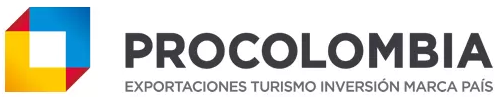

#### Objetivo de Proyecto


Crear un tablero que compile de forma automatizada indicadores de comercio exterior sobre la demanda de productos no minero-energéticos en diferentes mercados del mundo.

  

#### Metodología


- Se utiliza los datos de Procolombia ([*Trademap*](https://www.trademap.org/Index.aspx?lang=es)) de las exportaciones e importaciones realizadas por Colombia y de los demás países del mundo. Los datasets se componen de archivos planos por cada país que contienen información de códigos de productos de clasificación arancelarios HS6 y valor en USD de exportaciones e importaciones.

- Se desarrolla un ETL para el procesamiento de los datos para generar la plantilla que despliega el tablero.


- Se utiliza la librería Tableau para generar el archivo en formato hyper para el desarrollo del tablero.


Archivos de datos que son tablas de referencias:


- Códigos de productos de [clasificación arancelarios HS6](https://www.trademap.org/Index.aspx?lang=es)  (*Sectorización_HS6_20231005_uversion.xlsx*)

- [Códigos *ISO2*](https://uiaf.gov.co/sites/default/files/2022-06/documentos/archivos-anexos/Codigos%20paises%20ISO%203166Act.xlsx) de los países (*Codigos paises ISO 3166Act.xlsx*)


- [GeoDist](http://www.cepii.fr/CEPII/fr/bdd_modele/bdd_modele_item.asp?id=6) proporciona variables geográficas: (*geo_cepii.xlsx*)


## Instalacción de Librerías

In [ ]:
# Ignorar advertencias del código

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Datasets en drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Libreria de Tableu para generar el hyper para el tablero

!pip install tableauhyperapi
!pip install unidecode

In [ ]:
from tableauhyperapi import HyperProcess, Telemetry, Connection, TableName, TableDefinition, SqlType, CreateMode, Inserter

In [ ]:
import os
import pandas as pd
import re
import numpy as np
from unidecode import unidecode

## Procesamiento de los datos


### Clase del Proyecto


Leer los archivo de datos y las tablas de referencias para el desarrollo de ETL

In [ ]:
class ProjectExportsImports:
  #Carpetas
  folderExports = '/content/drive/MyDrive/project_procolombia/Files/Exportaciones'
  folderSaved = '/content/drive/MyDrive/project_procolombia/Files/ExportacionesSaved/'
  folderImports = '/content/drive/MyDrive/project_procolombia/Files/Importaciones'
  folderResults = '/content/drive/MyDrive/project_procolombia/Files/Resultados/'
  fileSectorization = '/content/drive/MyDrive/project_procolombia/Files/Sectorizacion/Sectorización_HS6_20231005_uversion.xlsx'
  fileCountries = '/content/drive/MyDrive/project_procolombia/Files/Paises/Codigos paises ISO 3166Act.xlsx'
  fileCountriesCepii = '/content/drive/MyDrive/project_procolombia/Files/Paises/geo_cepii.xlsx'

  #Años a procesar
  years = [2018, 2019, 2020, 2021, 2022]
  yearsString = list(map(str, years))

  #Columnas principales
  columnsRequired = ['Código del producto', 'Descripción del producto']

  #dataset de Sectorizaciones
  dfSectorizations = []
  dfCountries = []
  dfCountriesCepii = []
  dfCountriesMerge = []

  valuesFind = np.array(['Bosnia y Herzegovina', 'Curaçao', 'Autoridad Nacional Palestina'])
  valuesReplace = np.array(['Bosnia', 'Curazao', 'Palestina'])

  def executeMode(self):
    complementName = 'Col'

    self.folderExports = self.folderExports + complementName
    self.folderImports = self.folderImports + complementNamef
    print("Carpeta de Exportaciones: " + self.folderExports)
    print("Carpeta de Importaciones: " + self.folderImports)

  def callCountries(self):
    df = pd.read_excel(self.fileCountries, skiprows=1, header=None)

    #Tomar la primera fila como nombre de las columnas y sin espacios
    df.columns = df.iloc[0]
    df.columns = df.columns.str.strip()
    #Elimina el 1er registro
    df = df.iloc[1:].reset_index(drop=True)

    #Eliminar columna NaN
    df = df.dropna(axis=1, how='all')

    self.dfCountries = df
    return self.dfCountries

  def assignCountry(self, score):
    return self.valuesFind[np.where(self.valuesReplace == score)][0]

  def unidecodeF(self, text):
      return unidecode(text)

  def countriesMerge(self):
    dfCountry = self.dfCountries
    dfCountryCepii = self.dfCountriesCepii

    df_countries = pd.merge(dfCountry, dfCountryCepii, left_on='Código', right_on='iso2', how='left')
    df_countries = df_countries.drop('Código', axis=1)

    df_countries['País'] = df_countries['País'].replace(self.valuesFind, self.valuesReplace)
    df_countries['País'] = df_countries['País'].apply(lambda score: self.unidecodeF(score))

    self.countriesMerge = df_countries
    return self.countriesMerge

  def getCountries(self):
    return self.countriesMerge

  def callCountriesCepii(self):
    df = pd.read_excel(self.fileCountriesCepii)
    df = df[df['maincity'] == 1]

    #Columnas seleccionadas
    columnsRequired = ['iso2', 'iso3', 'cnum', 'country', 'area', 'dis_int', 'continent', 'city_en', 'lat', 'lon', 'cap', 'maincity', 'langoff_1']
    #Eliminar columnas que no sean las seleccionadas
    columnsDeleted = [col for col in df.columns if col not in columnsRequired]
    df = df.drop(columns=columnsDeleted)
    df = df.drop_duplicates()

    self.dfCountriesCepii = df
    return self.dfCountriesCepii

  def callSectorizacion(self):
    df = pd.read_excel(self.fileSectorization)
    df['HS6'] = df['HS6'].str.replace("'", '', regex=True)
    df['SubPartida'] = df['SubPartida'].apply(lambda x: x.strip())
    df['Mineros'] = df['Mineros'].apply(lambda x: x if x == 'No Mineras' else None)
    df = df.dropna(subset=['Mineros'])
    self.dfSectorizations = df

  def getSectorizacion(self):
      return self.dfSectorizations

  def assignTag(self, score):
    value = score
    compare = score.lower()
    if compare == 'Bahréin'.lower():
      value = 'Baréin'
    elif compare == 'Bangladesh'.lower():
      value = 'Bangladés'
    elif compare == 'Guinea-Bisáu'.lower():
      value = 'Guinea-Bissau'
    elif compare == 'Iraq'.lower():
      value = 'Irak'
    elif compare == 'Kuwai'.lower():
      value = 'Kuwait'
    elif compare == 'Montserra'.lower():
      value = 'Montserrat'
    elif compare == 'República Democratica del Congo'.lower():
      value = 'Rep. Dem. del Congo'
    elif compare == 'San Cristóbal Y Nieves'.lower():
      value = 'San Cristóbal y Nieves'
    elif compare == 'Qatar'.lower():
      value = 'Catar'
    elif compare == 'Congo'.lower():
      value = 'República del Congo'

    return self.unidecodeF(value)

  def loadFilesExportOrImport(self, nameFolder, columnType):
    dfs = []
    commonsColumns = set()

    files = os.listdir(nameFolder)
    for file in files:
      if file.endswith('.txt'):
        pathComplete = os.path.join(nameFolder, file)
        columnsName = pd.read_csv(pathComplete, sep='\t', nrows=0).columns.tolist()

        skiprows=0
        df = pd.read_csv(pathComplete, sep='\t', skiprows=skiprows)

        # Solo deja los columnas que se encuentren en years y las que se encuentren en columnsRequired.
        # Las que no cumplan, se les coloca None para luego ser eliminadas.
        df.columns = [col if (re.sub(r'[^0-9]', '', col) in self.yearsString) or (col in self.columnsRequired) else None for col in df.columns]
        # Eliminar las columnas con nombre None
        df = df.drop(columns=[col for col in df.columns if col is None])

        #Renombrar Columnas Exportaciones
        if columnType == 'EXPORTACIONES':
          df.columns = ['Colombia exporta al mundo-' + re.sub(r'[^0-9]', '', col) if re.search('exporta hacia el mundo', col) else col for col in df.columns]
          df.columns = ['Colombia exporta hacia País-' + re.sub(r'[^0-9]', '', col) if re.search('exporta hacia', col) else col for col in df.columns]
          df.columns = ['País Importa desde el mundo-' + re.sub(r'[^0-9]', '', col) if re.search('importa desde', col) else col for col in df.columns]
        elif columnType == 'IMPORTACIONES':
          df.columns = ['Colombia importa temp el mundo-' + re.sub(r'[^0-9]', '', col) if re.search('importa desde el mundo', col) else col for col in df.columns]
          df.columns = ['Colombia importa desde País-' + re.sub(r'[^0-9]', '', col) if re.search('importa desde', col) else col for col in df.columns]
          df.columns = ['Colombia importa desde el mundo-' + re.sub(r'[^0-9]', '', col) if re.search('importa temp el mundo', col) else col for col in df.columns]
          df.columns = ['País exporta hacia el mundo-' + re.sub(r'[^0-9]', '', col) if re.search('exporta hacia', col) else col for col in df.columns]

        # Elimina la fila de los Totales
        totals = df[df['Código del producto'].str.contains('TOTAL')]
        df = df[~df['Código del producto'].str.contains('TOTAL')]

        #Agrega Columnas de país y tipo
        df['país'] = file.replace(".txt", "")
        df['país'] = df['país'].apply(lambda score: self.assignTag(score))
        df['tipo'] = columnType

        #Realiza unpivot
        df = df.melt(id_vars=['Código del producto', 'Descripción del producto', 'tipo', 'país'], var_name='name', value_name='valor')
        df['años'] = df['name'].str.extract(r'(\d+)')
        df['name'] = df['name'].str.replace(r'\d', '', regex=True).str[:-1]

        #print("Número de filas Melted:", df.shape[0])

        #Filtramos solo los productos HS6
        df = df[df['Código del producto'].isin(self.dfSectorizations['HS6'])]

        #Convertimos el campo en número
        df['valor'] = pd.to_numeric(df['valor'], errors='coerce').fillna(0).astype(int)

        dfs.append(df.reset_index(drop=True))
    return pd.concat(dfs, ignore_index=True)

  def processData(self, nameFolder, columnType):
    dfData = self.loadFilesExportOrImport(nameFolder, columnType)

    # Se realiza pivote
    dfProcess = dfData.pivot_table(index=['Código del producto', 'Descripción del producto', 'tipo', 'país', 'años'], columns='name', values='valor', aggfunc='sum', fill_value=0)

    # Reiniciar el índice si es necesario
    dfProcess = dfProcess.reset_index()

    if columnType == 'EXPORTACIONES':
      dfProcess['Colombia importa desde el mundo'] = 0
      dfProcess['Colombia importa desde País'] = 0
      dfProcess['País exporta hacia el mundo'] = 0
    elif columnType == 'IMPORTACIONES':
      dfProcess['Colombia exporta al mundo'] = 0
      dfProcess['Colombia exporta hacia País'] = 0
      dfProcess['País Importa desde el mundo'] = 0

    #Habilitar exportar datos csv
    #dfProcess.to_csv(self.folderResults + columnType.lower() + '.csv', index=False)

    return dfProcess


### Ejecución del Proyecto




In [ ]:
project = ProjectExportsImports()

project.executeMode()

# Load Sectorizacion
project.callSectorizacion()

# Load Countries
project.callCountries()
project.callCountriesCepii()
project.countriesMerge()

dfExportsResult = project.processData(project.folderExports, 'EXPORTACIONES')
dfImportsResult = project.processData(project.folderImports, 'IMPORTACIONES')

df_concatenado = pd.concat([dfExportsResult, dfImportsResult], ignore_index=True)
df_concatenado = df_concatenado.drop('tipo', axis=1)
df_concatenado = df_concatenado.groupby(['Código del producto', 'Descripción del producto', 'país', 'años']).sum()

df_concatenado.shape[0]
df_concatenado = df_concatenado.reset_index()

#print(df_concatenado.tail(10))

df2 = project.getSectorizacion()
df2 = df2.reset_index()
#df2.head(10)

#['HS6', 'SubPartida', 'Cadena productiva', 'Sector', 'Subsector']
#Inner join de datos con la sectorizacion
dfSectorizado = pd.merge(df_concatenado, df2[['HS6', 'SubPartida', 'Cadena productiva', 'Sector', 'Subsector']], left_on='Código del producto', right_on='HS6', how='inner')
dfSectorizado = dfSectorizado.drop('HS6', axis=1)

df3 = project.getCountries()
df3 = df3.reset_index()

#Inner join de datos con el país
df_final = pd.merge(dfSectorizado, df3, left_on='país', right_on='País', how='inner')
df_final = df_final.drop('País', axis=1)

df_final['descripción'] = df_final['Descripción del producto'].str.replace("'", '', regex=True)
df_final['descripción'] = df_final['descripción'].apply(lambda x: x.strip())
df_final = df_final.drop('Descripción del producto', axis=1)
df_final = df_final.drop('index', axis=1)

#df_final.to_csv(project.folderResults + 'results_col.csv', index=False)

df_final["potencial sin explotar restante"] = (df_final["País Importa desde el mundo"] - df_final["Colombia exporta hacia País"]).astype("Int64")
df_final["exportación real"] = df_final["Colombia exporta hacia País"]
df_final["potencial exportación"] = df_final["País Importa desde el mundo"]

Carpeta de Exportaciones: /content/drive/MyDrive/project_procolombia/Files/ExportacionesCol
Carpeta de Importaciones: /content/drive/MyDrive/project_procolombia/Files/ImportacionesCol


Se puede observar a continuación la cantidad y tipo de datos que compone las variables:

In [ ]:
df_final.to_csv(project.folderResults + 'results.csv', index=False)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551075 entries, 0 to 4551074
Data columns (total 27 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Código del producto              object 
 1   país                             object 
 2   años                             object 
 3   Colombia exporta al mundo        int64  
 4   Colombia exporta hacia País      int64  
 5   País Importa desde el mundo      int64  
 6   Colombia importa desde el mundo  int64  
 7   Colombia importa desde País      int64  
 8   País exporta hacia el mundo      int64  
 9   SubPartida                       object 
 10  Cadena productiva                object 
 11  Sector                           object 
 12  Subsector                        object 
 13  iso2                             object 
 14  iso3                             object 
 15  cnum                             float64
 16  country                          object 
 17  area    

In [ ]:
df_final.head(2)

,Código del producto,país,años,Colombia exporta al mundo,Colombia exporta hacia País,País Importa desde el mundo,Colombia importa desde el mundo,Colombia importa desde País,País exporta hacia el mundo,SubPartida,...,area,dis_int,continent,city_en,lat,lon,cap,maincity,langoff_1,descripción
0,010121,Afganistan,2018,1033,0,15561,522,0,0,Subpartida 010121 Descripción no disponible,...,652225.0,303.7614,Asia,Kabul,34.51667,69.2,1.0,1.0,Persian,Caballos reproductores de raza pura
1,010121,Afganistan,2019,372,0,2771,590,0,0,Subpartida 010121 Descripción no disponible,...,652225.0,303.7614,Asia,Kabul,34.51667,69.2,1.0,1.0,Persian,Caballos reproductores de raza pura


##  Extraer Hyper Tableau


In [ ]:
df_final['dis_int'].value_counts(dropna=True)

dis_int
76.95715     50850
3.79869      50850
120.22700    50850
303.76140    25425
361.50580    25425
             ...  
399.31920    25425
206.01290    25425
218.21590    25425
50.92729     25425
235.11930    25425
Name: count, Length: 176, dtype: int64

In [ ]:


# Se declara los formatos de las columnas
columnsInts = ['Colombia exporta al mundo', 'País Importa desde el mundo', 'Colombia exporta hacia País', 'País exporta hacia el mundo', 'Colombia importa desde País', 'Colombia importa desde el mundo', "potencial sin explotar restante", "exportación real", "potencial exportación"]
for key in columnsInts:
    df_final[key] = df_final[key].fillna(0).astype(int)

columnsFloat = ['cnum', 'dis_int', 'area', 'cap', 'maincity', 'lat', 'lon']
for key in columnsFloat:
    df_final[key] = df_final[key].fillna(0).astype(float)

columnsText = ['Código del producto', 'descripción', 'país', 'años', 'SubPartida', 'Cadena productiva', 'Sector', 'Subsector', 'iso2', 'iso3', 'country', 'continent', 'city_en', 'langoff_1']
for key in columnsText:
    df_final[key] = df_final[key].fillna('')




# Definir la estructura de la tabla
table_definition = TableDefinition(table_name='Extract',
                                    columns=[
                                        TableDefinition.Column('Código del producto', SqlType.text()),
                                        TableDefinition.Column('descripción', SqlType.text()),
                                        TableDefinition.Column('país', SqlType.text()),
                                        TableDefinition.Column('años', SqlType.text()),
                                        TableDefinition.Column('Colombia exporta al mundo', SqlType.big_int()),
                                        TableDefinition.Column('País Importa desde el mundo', SqlType.big_int()),
                                        TableDefinition.Column('Colombia exporta hacia País', SqlType.big_int()),
                                        TableDefinition.Column('País exporta hacia el mundo', SqlType.big_int()),
                                        TableDefinition.Column('Colombia importa desde País', SqlType.big_int()),
                                        TableDefinition.Column('Colombia importa desde el mundo', SqlType.big_int()),
                                        TableDefinition.Column('SubPartida', SqlType.text()),
                                        TableDefinition.Column('Cadena productiva', SqlType.text()),
                                        TableDefinition.Column('Sector', SqlType.text()),
                                        TableDefinition.Column('Subsector', SqlType.text()),
                                        TableDefinition.Column('iso2', SqlType.text()),
                                        TableDefinition.Column('iso3', SqlType.text()),
                                        TableDefinition.Column('cnum', SqlType.double()),
                                        TableDefinition.Column('country', SqlType.text()),
                                        TableDefinition.Column('area', SqlType.double()),
                                        TableDefinition.Column('dis_int', SqlType.double()),
                                        TableDefinition.Column('continent', SqlType.text()),
                                        TableDefinition.Column('city_en', SqlType.text()),
                                        TableDefinition.Column('lat', SqlType.double()),
                                        TableDefinition.Column('lon', SqlType.double()),
                                        TableDefinition.Column('cap', SqlType.double()),
                                        TableDefinition.Column('maincity', SqlType.double()),
                                        TableDefinition.Column('langoff_1', SqlType.text()),
                                        TableDefinition.Column('potencial sin explotar restante', SqlType.big_int()),
                                        TableDefinition.Column('exportación real', SqlType.big_int()),
                                        TableDefinition.Column('potencial exportación', SqlType.big_int())
                                    ])


# Función para insertar los datos en la tabla
def insert_data_into_hyper(process):
    with Connection(endpoint=process.endpoint, database=project.folderResults + 'prueba3.hyper', create_mode=CreateMode.CREATE_AND_REPLACE) as connection:

      # Crear la tabla en el archivo Hyper
      connection.catalog.create_table(table_definition)


      # Iniciar un inserter para agregar datos a la tabla
      with Inserter(connection, table_definition) as inserter:
        # Insertar filas de datos en la tabla a partir del DataFrame
        #inserter.add_rows_from_iterator(df_final.itertuples(index=False, name=None))

        # Insertar filas de datos en la tabla a partir del DataFrame
        for index, row in df_final.iterrows():
          inserter.add_row([row['Código del producto'], row['descripción'], row['país'], row['años'], row['Colombia exporta al mundo'], row['País Importa desde el mundo'], row['Colombia exporta hacia País'], row['País exporta hacia el mundo'], row['Colombia importa desde País'], row['Colombia importa desde el mundo'], row['SubPartida'], row['Cadena productiva'], row['Sector'], row['Subsector'], row['iso2'], row['iso3'], row['cnum'], row['country'], row['area'], row['dis_int'], row['continent'], row['city_en'], row['lat'], row['lon'], row['cap'], row['maincity'], row['langoff_1'], row['potencial sin explotar restante'], row['exportación real'], row['potencial exportación']])

        # Finalizar la inserción de datos
        inserter.execute()


# Proceso principal para exportar los datos
def export_data_to_hyper():
    with HyperProcess(telemetry=Telemetry.SEND_USAGE_DATA_TO_TABLEAU) as process:
        insert_data_into_hyper(process)


# Exportar los datos
export_data_to_hyper()


print(f"Archivo Hyper generado en Google Drive")

Archivo Hyper generado en Google Drive


# Sección nueva